Change Runtime type to T4 GPU

**3D Mesh Generation from Single Image**

In [ ]:
# Install required packages
!pip install open3d matplotlib timm opencv-python --quiet

# Fix Open3D headless rendering in Colab
import os
os.environ["OPEN3D_CPU_RENDERING"] = "true"


Note: Upload an image to google collab copy its path then paste it in img_path below

Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master
/usr/local/lib/python3.11/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master


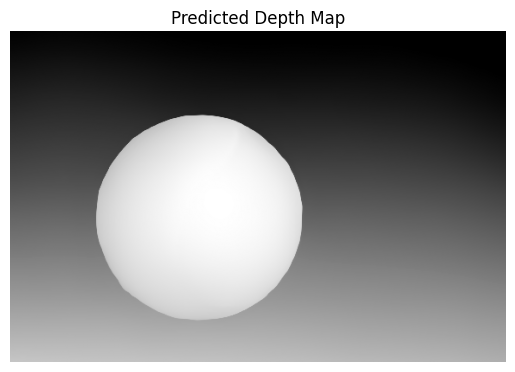

Generating mesh with Poisson reconstruction...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import torch
import numpy as np
import open3d as o3d
import matplotlib.pyplot as plt
from PIL import Image
from torchvision.transforms import Compose
import cv2

# MiDaS model from Intel-ISL
midas = torch.hub.load("intel-isl/MiDaS", "DPT_Large")
midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")

# Send model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
midas.to(device)
midas.eval()

# Choose the right transform for this model
transform = midas_transforms.dpt_transform

# Load image using PIL
img_path = "/content/IMG_20240629_090127635.jpg"  # change this path
image = Image.open(img_path).convert("RGB")
image_np = np.array(image)  # Convert to NumPy array

# Transform the image
input_tensor = transform(image_np).to(device)

# Predict
with torch.no_grad():
    prediction = midas(input_tensor)
    depth = prediction.squeeze().cpu().numpy()

# Normalize depth to 0–255 for visualization and Open3D
depth_min, depth_max = depth.min(), depth.max()
depth_normalized = (255 * (depth - depth_min) / (depth_max - depth_min)).astype("uint8")

# Show depth
plt.imshow(depth_normalized, cmap="gray")
plt.title("Predicted Depth Map")
plt.axis("off")
plt.show()

# Resize original image to match depth
resized_image = image.resize(depth_normalized.shape[::-1])
color_np = np.asarray(resized_image)
depth_np = depth_normalized

# Convert to Open3D images
color_o3d = o3d.geometry.Image(color_np)
depth_o3d = o3d.geometry.Image(depth_np)

# Create RGBD image
rgbd_image = o3d.geometry.RGBDImage.create_from_color_and_depth(
    color_o3d, depth_o3d,
    depth_scale=1.0,  # Already scaled
    convert_rgb_to_intensity=False
)

# Set a basic pinhole camera intrinsic
height, width = depth_np.shape
fx = fy = 500.0
cx, cy = width / 2, height / 2
intrinsics = o3d.camera.PinholeCameraIntrinsic(width, height, fx, fy, cx, cy)

# STEP 7: Create point cloud
pcd = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd_image, intrinsics)
pcd.estimate_normals()

# STEP 8: Create mesh using Poisson reconstruction
print("Generating mesh with Poisson reconstruction...")
mesh, _ = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(pcd, depth=9)
bbox = pcd.get_axis_aligned_bounding_box()
mesh = mesh.crop(bbox)

# STEP 9: Save and visualize
o3d.io.write_triangle_mesh("mesh_poisson.ply", mesh)

from google.colab import files
files.download("mesh_poisson.ply")